In [260]:
!pip install seaborn

In [1]:

from rl_environments.singleagent_oneoven import OverCookedSingleAgentOneOven
from rl_environments.singleagent_dualtask import OverCookedSingleAgentDualtask
# from rl_environments.singleagent_dualtask_delayedreward import OverCookedSingleAgentDualtaskDelayedReward

In [2]:
from model_wrappers.sb3CnnLstmMlpWrapper import sb3CnnLstmMlpWrapper
# from model_wrappers.sb3CnnMlpWrapper import sb3CnnMlpWrapper

In [3]:
from analysis.layer_output_calculator import LayerOutputCalculator
from analysis.utils import neural_activations_by_timestep,fft,pca
from utils.get_first_oven_check import get_oven_checks

In [4]:
from sb3_contrib import RecurrentPPO
# from stable_baselines3 import PPO

In [5]:
import torch as th
import torch.nn as nn
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy import stats
import json
import pandas as pd

In [6]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# get first oven checks for 25 runs across different durations

In [10]:


first_oven_checks_dict = {}
first_oven_checks_dict_agid = {}
first_oven_checks_dualtask_dict = {}
first_oven_checks_dualtask_dict_agid = {}
total_rewards_dict = {}
total_reward_dualtask_dict = {}

for iter in range(25):

    first_oven_checks_dict_agid[iter] = {}
    first_oven_checks_dualtask_dict_agid[iter] = {}

    for target_duration in [8,9]: # add all target durations
        reward_check = 0
        env_dur = OverCookedSingleAgentOneOven(oven_duration=target_duration)
        env_dualtask_dur = OverCookedSingleAgentDualtask(oven_duration=target_duration)

        if target_duration!=8:
            model_lstm = RecurrentPPO.load(f"models/singleagentv3_oneoven_T{target_duration}_cnnoutput125_timestep500_entcoef05_cnnlstmmlp_logs/rl_model_100000_steps", env=env_dur)

            model_dualtask= RecurrentPPO.load(f"models/singleagentv3_clblock_T{target_duration}_cnnoutput125_timestep500_entcoef05_cnnlstmmlp_logs/rl_model_100000_steps", env=env_dualtask_dur)

        else:
            model_lstm = RecurrentPPO.load(f"models/singleagentv3_oneoven_T{target_duration}_cnnoutput125_timestep500_entcoef05_cnnlstmmlp_logs/rl_model_100000_steps", env=env_dur)
            model_dualtask= RecurrentPPO.load(f"models/singleagent_clblock_T{target_duration}_timesteps500_entoef05_logs/rl_model_100000_steps", env=env_dualtask_dur)

        # else:
        #     continue

        wrapped_lstm_model = sb3CnnLstmMlpWrapper(model_lstm)
        wrapped_lstm_dualtask_model = sb3CnnLstmMlpWrapper(model_dualtask)


        lstm_outputcalculator = LayerOutputCalculator(wrapped_lstm_model, model_lstm, env_dur)
        # cnn_outputcalculator = LayerOutputCalculator(wrapped_cnnmlp_t8_model,model_cnnmlp_t8, env_dur8, has_lstm=False)
        lstm_dualtask_outputcalculator = LayerOutputCalculator(wrapped_lstm_dualtask_model, model_dualtask, env_dualtask_dur)


        while reward_check<2:

            while True:
                first_obs,_ = env_dur.reset(seed=10)
                if np.where(first_obs[:,:,1]==1) == (4,1) :
                    print("duration not processed", target_duration)
                    continue
                break

            lstm_outputcalculator.get_layer_outputs_per_episode(first_obs)
            lstm_dualtask_outputcalculator.get_layer_outputs_per_episode(first_obs, timesteps=101)

            if (np.sum(lstm_outputcalculator.rewards) <= 2) or (np.sum(lstm_dualtask_outputcalculator.rewards) <= 2):
                reward_check += 1
                continue
            break

        first_oven_checks, _ = get_oven_checks(lstm_outputcalculator.actions, lstm_outputcalculator.oven_timer, target_duration)
        first_oven_checks_dict_agid[iter][target_duration] = first_oven_checks_dict_agid[iter].get(target_duration,[]) + first_oven_checks
        first_oven_checks_dict[target_duration] = first_oven_checks_dict.get(target_duration,[]) + first_oven_checks
        total_rewards_dict[target_duration] = total_rewards_dict.get(target_duration,[]) + [np.sum(lstm_outputcalculator.rewards)]

        first_oven_checks, _ = get_oven_checks(lstm_dualtask_outputcalculator.actions, lstm_dualtask_outputcalculator.oven_timer, target_duration)
        first_oven_checks_dualtask_dict_agid[iter][target_duration] = first_oven_checks_dualtask_dict_agid[iter].get(target_duration,[])  + first_oven_checks
        first_oven_checks_dualtask_dict[target_duration] = first_oven_checks_dualtask_dict.get(target_duration,[])  + first_oven_checks
        total_reward_dualtask_dict[target_duration] = total_reward_dualtask_dict.get(target_duration,[]) + [np.sum(lstm_dualtask_outputcalculator.rewards)]

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[[0 3 4]
 [0 0 0]
 [5 1 0]
 [0 0 0]
 [0 0 0]]
action 3
reward 0
timestep 1
oven timer -1
[[0 3 4]
 [0 0 0]
 [5 0 1]
 [0 0 0]
 [0 0 0]]
action 2
reward 0
timestep 2
oven timer -1
[[0 3 4]
 [0 0 1]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 4
reward 0
timestep 3
oven timer -1
[[0 3 4]
 [0 1 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 4
reward 0
timestep 4
oven timer -1
[[0 3 4]
 [1 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 2
reward 0
timestep 5
oven timer -1
[[1 3 4]
 [0 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 2
reward 0
timestep 6
oven timer -1
[[1 3 4]
 [0 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 2
reward 0
timestep 7
oven timer -1
[[1 3 4]
 [0 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 4
reward 0
timestep 8
oven timer -1
[[1 3 4]
 [0 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 4
reward 0
timestep 9
oven timer -1
[[1 3 4]
 [0 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]

In [ ]:
# save first oven check dict
with open(f'overcooked_runs_dur7.json', 'w') as f:
    json.dump(first_oven_checks_dict, f)

with open(f'overcooked_dualtask_runs_dur7.json', 'w') as f:
    json.dump(first_oven_checks_dualtask_dict, f)

# performance of each agent

In [11]:

rows = []
for agent_id, dur_dict in first_oven_checks_dict_agid.items():
    for target_dur, oven_list in dur_dict.items():

        oven_list_TN = first_oven_checks_dualtask_dict_agid.get(agent_id, {}).get(target_dur, [])
        
        rows.append({
            "agent id": agent_id,
            "target duration": target_dur,
            "oven checks (T)": oven_list,
            "number of oven checks (T)": len(oven_list),
            "oven checks (T + N)": oven_list_TN,
            "number of oven checks (T + N)": len(oven_list_TN),
            
        })

df = pd.DataFrame(rows)
df

agent id  target duration oven checks (T)  number of oven checks (T)  \
0          0                8       [7, 7, 7]                          3   
1          0                9    [7, 4, 4, 4]                          4   
2          1                8       [9, 7, 7]                          3   
3          1                9    [9, 4, 4, 4]                          4   
4          2                8              []                          0   
5          2                9    [7, 4, 4, 4]                          4   
6          3                8    [7, 7, 7, 7]                          4   
7          3                9    [8, 4, 4, 4]                          4   
8          4                8       [7, 7, 7]                          3   
9          4                9    [9, 4, 4, 4]                          4   
10         5                8       [9, 7, 7]                          3   
11         5                9    [7, 7, 4, 4]                          4   
12         6                8       [7, 7, 7]                          3   
13         6                9    [4, 4, 4, 4]                          4   
14         7                8       [7, 7, 7]                          3   
15         7                9    [8, 4, 4, 4]                          4   
16         8                8       [8, 7, 7]                          3   
17         8                9    [7, 7, 4, 4]                          4   
18         9                8       [8, 7, 7]                          3   
19         9                9    [7, 4, 4, 4]                          4   
20        10                8    [7, 7, 7, 7]                          4   
21        10                9    [7, 4, 4, 4]                          4   
22        11                8    [7, 7, 7, 7]                          4   
23        11                9   [-1, 6, 4, 4]                          4   
24        12                8    [7, 7, 7, 7]                          4   
25        12                9    [8, 4, 4, 4]                          4   
26        13                8              []                          0   
27        13                9    [8, 4, 4, 4]                          4   
28        14                8       [7, 7, 7]                          3   
29        14                9    [8, 4, 4, 4]                          4   
30        15                8              []                          0   
31        15                9   [10, 6, 4, 4]                          4   
32        16                8    [7, 7, 7, 7]                          4   
33        16                9    [7, 7, 4, 4]                          4   
34        17                8       [9, 7, 7]                          3   
35        17                9    [9, 4, 4, 4]                          4   
36        18                8       [9, 7, 7]                          3   
37        18                9    [9, 4, 4, 4]                          4   
38        19                8    [7, 7, 7, 7]                          4   
39        19                9    [8, 4, 4, 4]                          4   
40        20                8    [7, 7, 7, 7]                          4   
41        20                9    [8, 4, 4, 4]                          4   
42        21                8    [7, 7, 7, 7]                          4   
43        21                9    [8, 4, 4, 4]                          4   
44        22                8    [7, 7, 7, 7]                          4   
45        22                9    [9, 4, 4, 4]                          4   
46        23                8    [7, 7, 7, 7]                          4   
47        23                9   [10, 6, 4, 4]                          4   
48        24                8       [9, 7, 7]                          3   
49        24                9    [7, 7, 4, 4]                          4   

          oven checks (T + N)  number of oven checks (T + N)  
0              [10, 9, 9, 10]                              4  
1

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17568\1407518147.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17568\1407518147.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(


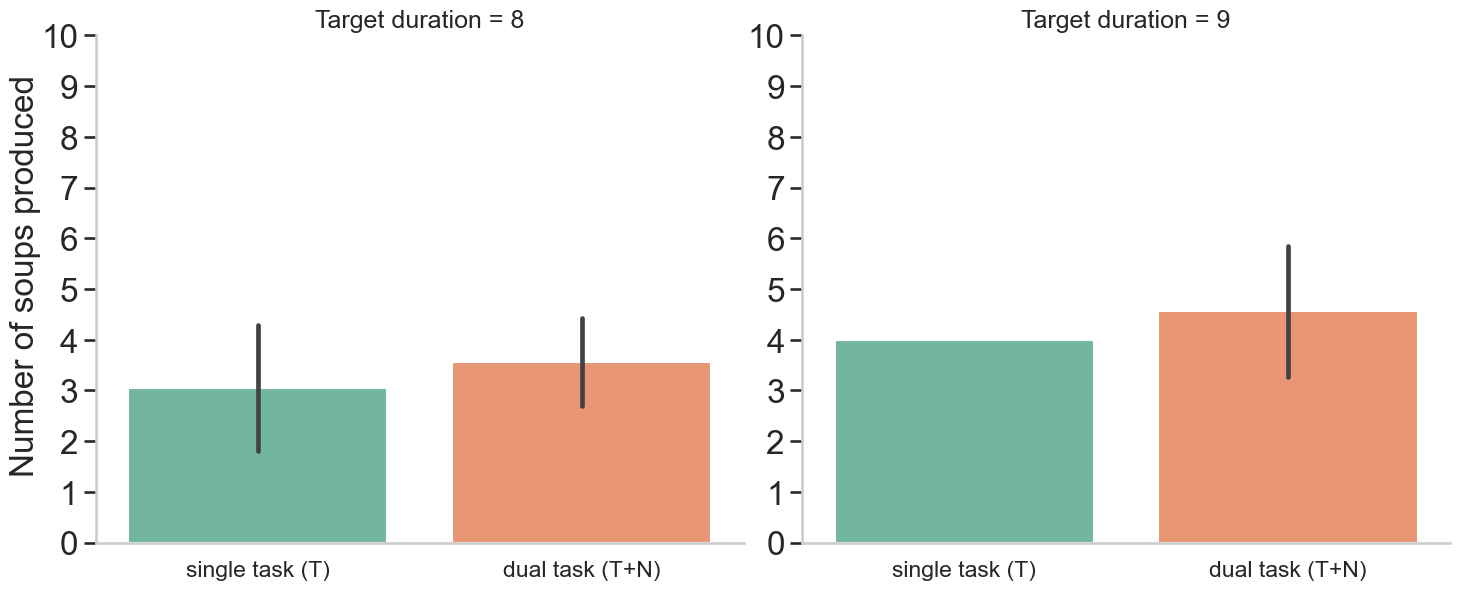

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Assume your dataframe is named df ---

# Convert to long format for easy plotting
df_long = df.melt(
    id_vars=["agent id", "target duration"],
    value_vars=["number of oven checks (T)", "number of oven checks (T + N)"],
    var_name="Task Type",
    value_name="Number of Oven Checks"
)

# Plot settings
sns.set(style="whitegrid", context="talk")

g = sns.catplot(
    data=df_long,
    x="Task Type",
    y="Number of Oven Checks",
    col="target duration",
    kind="bar",
    palette="Set2",
    col_wrap=4,
    height=6,
    aspect=1.2,
    sharex=False,
    sharey=False,
    ci="sd"   # show variability across agents
)

# Customize titles, labels, and ticks
g.set_titles("Target duration = {col_name}", fontsize=24)

# g.set_axis_labels("", "Number of oven checks")
# plt.yticks(range(0, 10), fontsize=15)

g.fig.text(0, 0.6, "Number of soups produced", va='center', rotation='vertical', fontsize=24)

# Remove x labels and ticks
for ax in g.axes.flatten():
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["single task (T)", "dual task (T+N)"])
    ax.set_yticks(range(0, 11, 1))
    ax.tick_params(axis='y', labelsize=24, )
    # ax.tick_params(axis='x')
    ax.grid(False)
    ax.set_ylim(bottom=0,top=10)
    ax.yaxis.set_ticks_position('left')

# Add overall title
# g.fig.suptitle("Number of first Oven Checks Across Task Types and Durations", fontsize=16)
plt.subplots_adjust( top=1)

plt.show()
# g.savefig("coginterp/number_of_soups_produced.png", dpi=300, bbox_inches='tight')

In [10]:
df.groupby(["target duration"])[["number of oven checks (T)", "number of oven checks (T + N)"]].describe()

number of oven checks (T)                                      \
                                    count  mean       std  min  25%  50%  75%   
target duration                                                                 
7                                    25.0  7.00  0.000000  7.0  7.0  7.0  7.0   
8                                    25.0  3.40  0.500000  3.0  3.0  3.0  4.0   
9                                    25.0  4.00  0.000000  4.0  4.0  4.0  4.0   
10                                   25.0  4.72  1.021437  0.0  5.0  5.0  5.0   

                     number of oven checks (T + N)                            \
                 max                         count  mean       std  min  25%   
target duration                                                                
7                7.0                          25.0  4.80  0.408248  4.0  5.0   
8                4.0                          25.0  3.56  0.869866  0.0  3.0   
9                4.0                          25.0  4.68  0.852447  3.0  4.0   
10               5.0                          25.0  2.52  0.714143  0.0  2.0   

                                
                 50%  75%  max  
target duration                 
7                5.0  5.0  5.0  
8                4.0  4.0  4.0  
9                5.0  5.0  7.0  
10               3.0  3.0  3.0

In [23]:
pd.DataFrame([total_rewards_dict[8], total_reward_dualtask_dict[8]])

0   1   2   3   4   5   6   7   8   9   ...  15  16  17  18  19  20  21  \
0   4   3   3   4   4   3   4   3   3   3  ...   4   3   3   4   4   4   4   
1  13  11  13  15  13  14  13  12  14  14  ...  14  15  13  14  13  14  13   

   22  23  24  
0   3   3   3  
1  12   0  14  

[2 rows x 25 columns]

<Axes: >

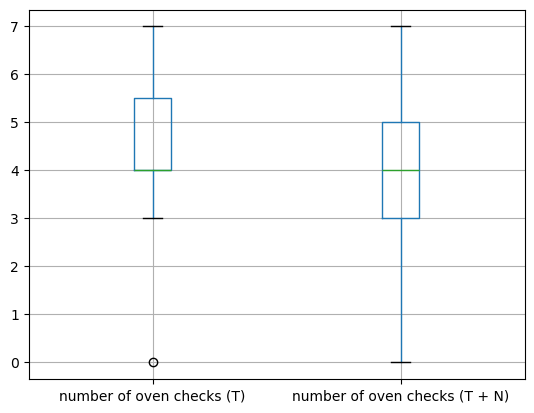

In [12]:
df[["number of oven checks (T)", "number of oven checks (T + N)"]].boxplot()

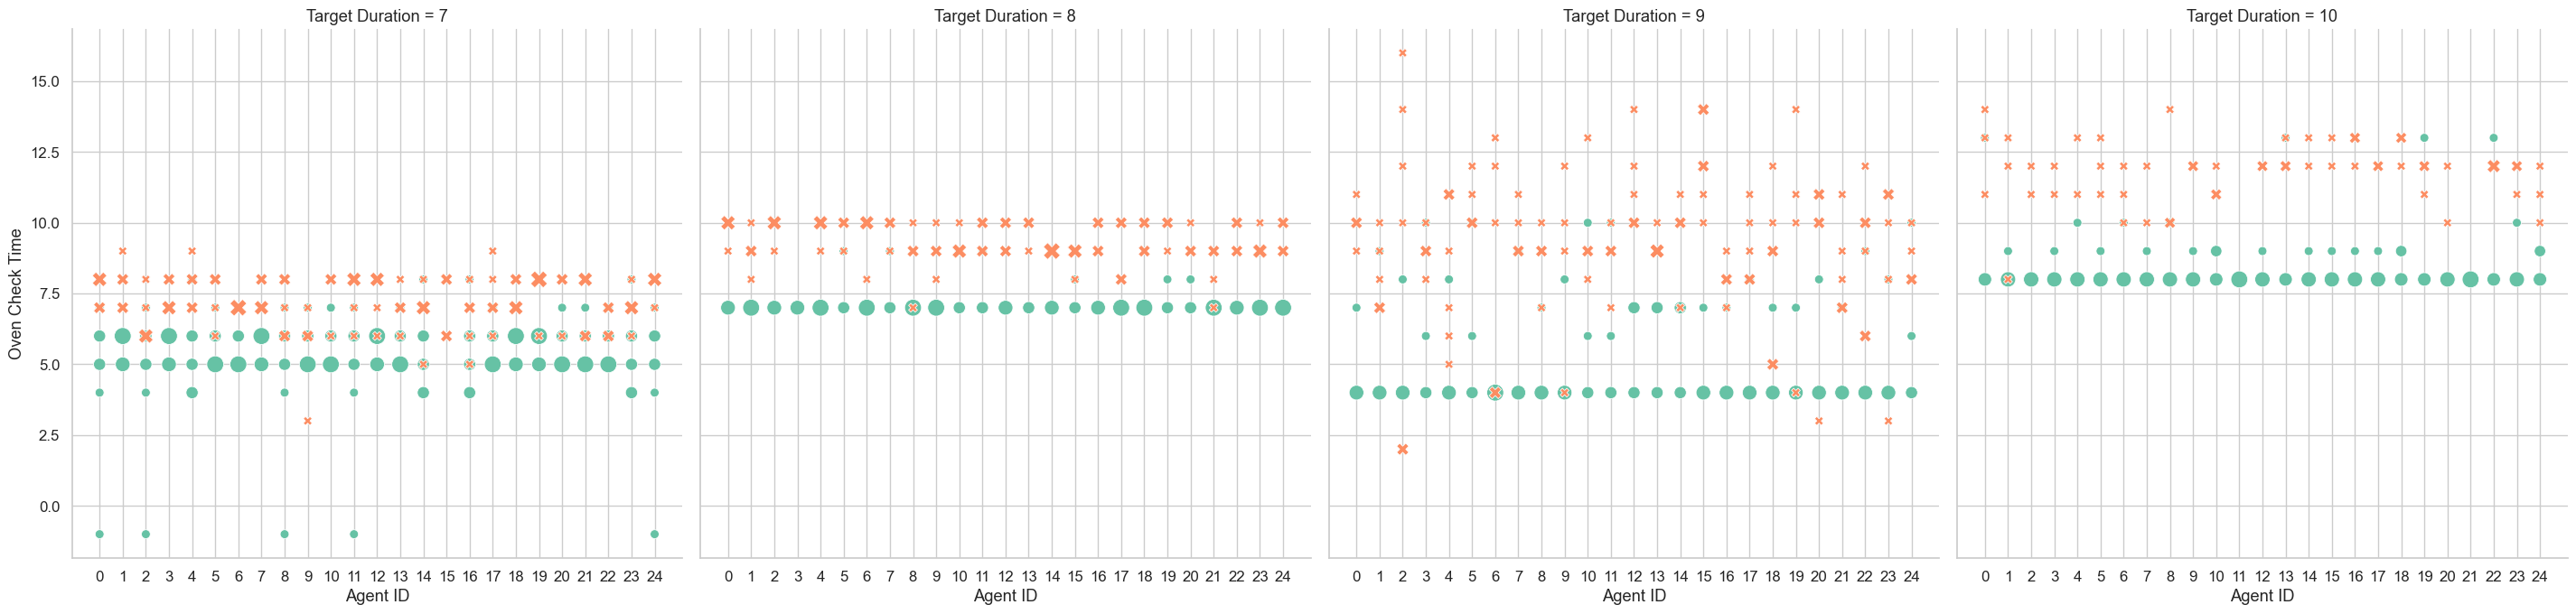

In [123]:
# Oven check time by agent ID. To check


records = []
for _, row in df.iterrows():
    dur = row["target duration"]
    for t in row["oven checks (T)"]:
        records.append({"agent id": row["agent id"], "task": "T", "check time": t, "duration": dur})
    for t in row["oven checks (T + N)"]:
        records.append({"agent id": row["agent id"], "task": "T+N", "check time": t, "duration": dur})

long_df = pd.DataFrame(records)

# --- Count overlapping checks per agent & task & time & duration ---
size_df = long_df.groupby(["duration", "agent id", "task", "check time"]).size().reset_index(name="count")

# --- FacetGrid plot ---
g = sns.FacetGrid(size_df, col="duration", col_wrap=20, height=7, sharey=True)
g.map_dataframe(
    sns.scatterplot,
    x="agent id",
    y="check time",
    hue="task",
    style="task",
    size="count",
    sizes=(50, 180),
    alpha=1,
    palette="Set2"
)

agent_ids = sorted(df["agent id"].unique())
for ax in g.axes.flatten():
    ax.set_xticks(agent_ids)

    
g.set_axis_labels("Agent ID", "Oven Check Time")
# g.add_legend(title="Task / # Checks")
g.set_titles("Target Duration = {col_name}")
plt.tight_layout()
plt.show()


# Plot agent path

In [7]:
# make path animation
def animate_path(model_obj, save_path):

    # Data setup
    num_frames = len(model_obj.dataset_train)

    fig, ax = plt.subplots(figsize=(6, 6))
    img_display = ax.imshow(
        np.sum(model_obj.dataset_train[0][0].detach().numpy(), axis=2),
        cmap='magma', vmin=0, vmax=5
    )
    title = ax.set_title("", fontsize=16)
    ax.axis('off')

    def update(frame):
        frame_data = np.sum(
            model_obj.dataset_train[frame][0].detach().numpy(), axis=2
        )
        img_display.set_array(frame_data)
        action = model_obj.actions[frame]
        ax.set_title(f"Oven timer: {model_obj.oven_timer[frame]}. Action: {model_obj.actions[frame]}. Timestep: {frame}" )
        return [img_display]

    # Create animation
    anim = FuncAnimation(fig, update, frames=num_frames, interval=500, blit=False)

    # Save as GIF
    anim.save(save_path)
    # plt.close(fig)
    HTML(anim.to_jshtml())

In [18]:
reward_check = 0
target_duration = 10
env_dur = OverCookedSingleAgentOneOven(oven_duration=target_duration)
env_dualtask_dur = OverCookedSingleAgentDualtask(oven_duration=target_duration)


model_lstm = RecurrentPPO.load(f"models/singleagentv3_oneoven_T{target_duration}_cnnoutput125_timestep500_entcoef05_cnnlstmmlp_logs/rl_model_100000_steps", env=env_dur)

model_dualtask= RecurrentPPO.load(f"models/singleagentv3_clblock_T{target_duration}_cnnoutput125_timestep500_entcoef05_cnnlstmmlp_logs/rl_model_100000_steps", env=env_dualtask_dur)



wrapped_lstm_model = sb3CnnLstmMlpWrapper(model_lstm)
wrapped_lstm_dualtask_model = sb3CnnLstmMlpWrapper(model_dualtask)


lstm_outputcalculator = LayerOutputCalculator(wrapped_lstm_model, model_lstm, env_dur)
lstm_dualtask_outputcalculator = LayerOutputCalculator(wrapped_lstm_dualtask_model, model_dualtask, env_dualtask_dur)


# while reward_check<2:
#
#     while True:
#         first_obs,_ = env_dur.reset(seed=10)
#         if np.where(first_obs[:,:,1]==1) == (4,1) :
#             print("duration not processed", target_duration)
#             continue
#         break

lstm_outputcalculator.get_layer_outputs_per_episode(first_obs)
lstm_dualtask_outputcalculator.get_layer_outputs_per_episode(first_obs, timesteps=101)

    # if (np.sum(lstm_outputcalculator.rewards) <= 2) or (np.sum(lstm_dualtask_outputcalculator.rewards) <= 2):
    #     reward_check += 1
    #     continue
    # break


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[[0 3 4]
 [0 0 0]
 [5 0 1]
 [0 0 0]
 [0 0 0]]
action 2
reward 0
timestep 1
oven timer -1
[[0 3 4]
 [0 0 1]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 4
reward 0
timestep 2
oven timer -1
[[0 3 4]
 [0 1 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 4
reward 0
timestep 3
oven timer -1
[[0 3 4]
 [1 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 2
reward 0
timestep 4
oven timer -1
[[1 3 4]
 [0 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 5
reward 0
timestep 5
oven timer -1
[[2 3 4]
 [0 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 4
reward 0
timestep 6
oven timer -1
[[2 3 4]
 [0 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 1
reward 0
timestep 7
oven timer -1
[[0 3 4]
 [2 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 5
reward 0
timestep 8
oven timer 1
[[0 3 4]
 [1 0 0]
 [6 0 0]
 [0 0 0]
 [0 0 0]]
action 5
reward 0
timestep 9
oven timer 2
[[0 3 4]
 [1 0 0]
 [6 0 0]
 [0 0 0]
 [0 0 0]]
a

# single task (T) agent path

MovieWriter ffmpeg unavailable; using Pillow instead.


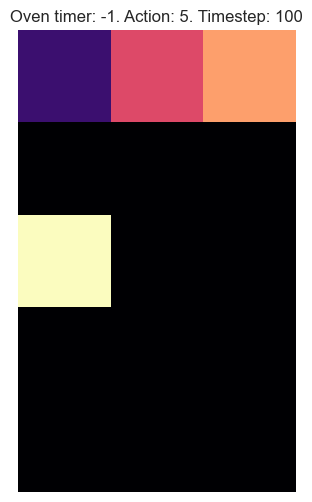

In [19]:
# animation
animate_path(lstm_outputcalculator, "lstm_singletask_animation.gif")

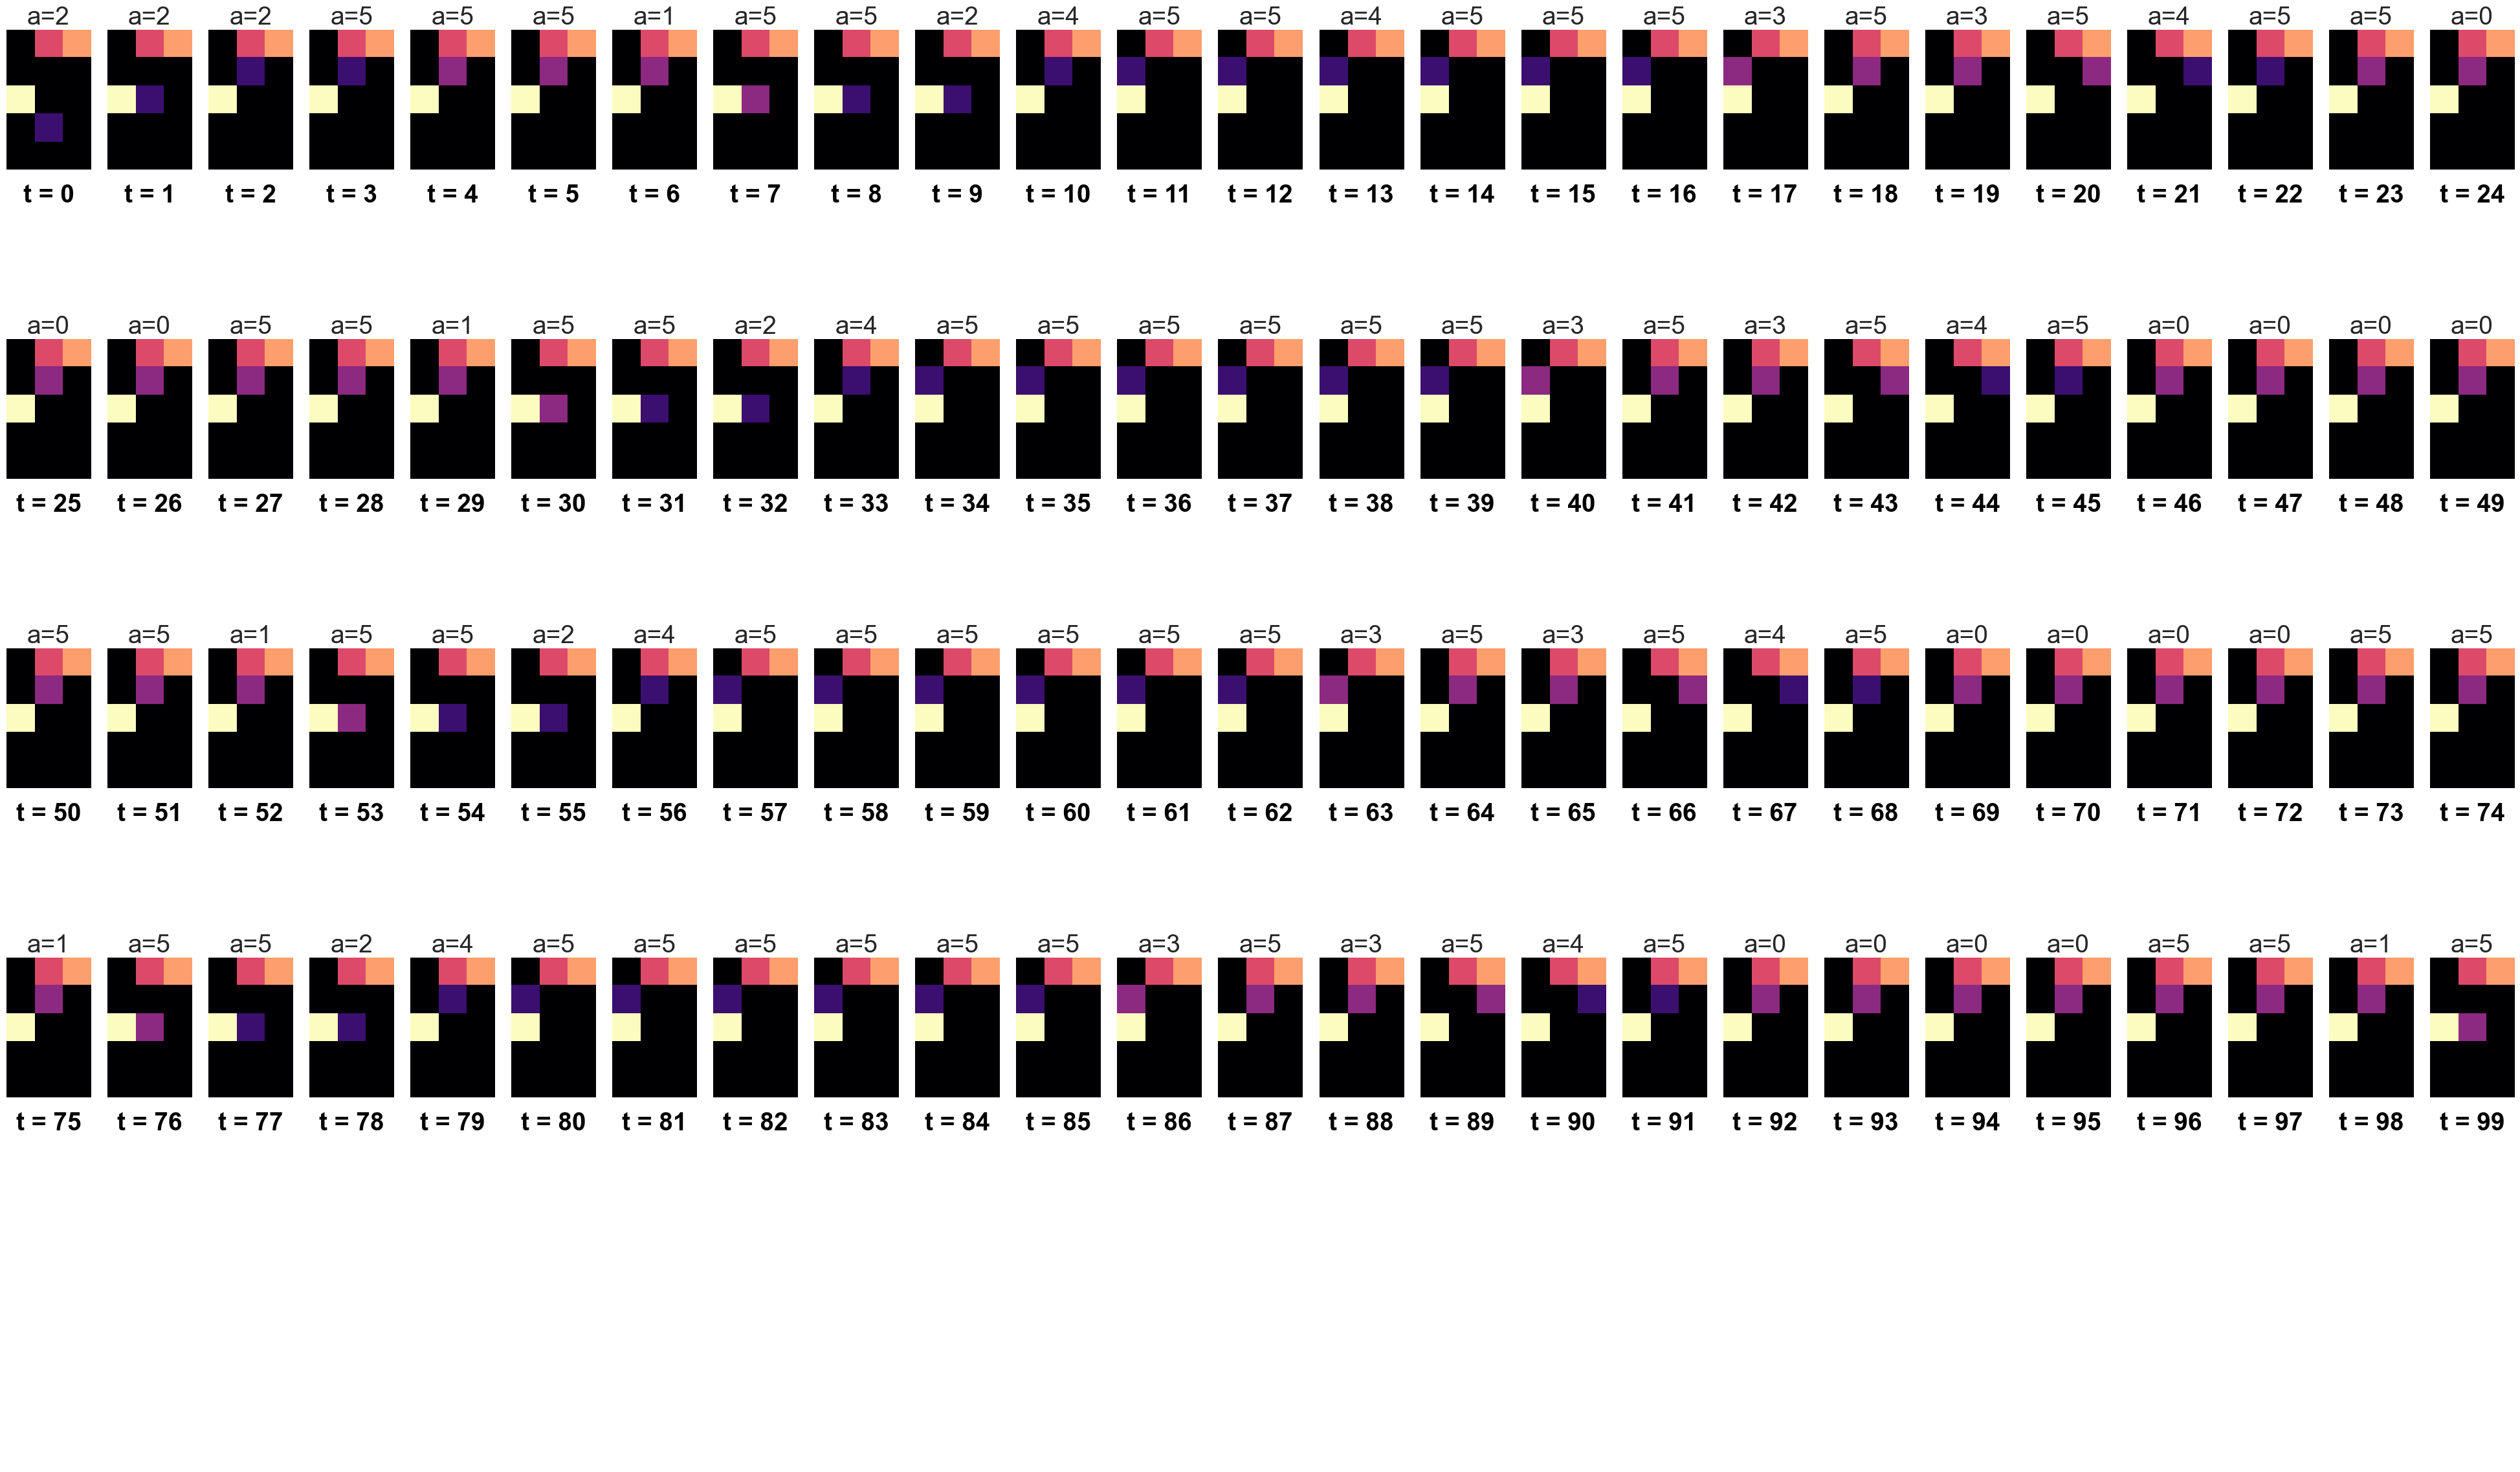

In [32]:
import matplotlib.pyplot as plt
import numpy as np

num_frames = len(lstm_outputcalculator.dataset_train[0:100])

# Select up to 125 timesteps evenly spaced
max_frames = 5 * 25
timesteps = np.linspace(0, num_frames-1, min(num_frames, max_frames), dtype=int)

rows, cols = 5, 25
fig, axes = plt.subplots(rows, cols, figsize=(50, 30))  # adjust figsize as needed

for idx, t in enumerate(timesteps):
    row = idx // cols
    col = idx % cols

    img = np.sum(lstm_outputcalculator.dataset_train[t][0].detach().numpy(), axis=2)
    axes[row, col].imshow(img, cmap = 'magma', vmin=0, vmax=5)
    axes[row, col].set_title(f"a={lstm_outputcalculator.actions[t]}", fontsize=28)
    axes[row, col].text(1, 5, f"t = {t}", color='black', fontsize=28,
        ha='center', va='top', fontweight='bold')
    axes[row, col].axis('off')

# Hide any unused subplots
for idx in range(len(timesteps), rows*cols):
    row = idx // cols
    col = idx % cols
    axes[row, col].axis('off')

# fig.suptitle("Evolution of Input Frames Over Time", fontsize=14)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



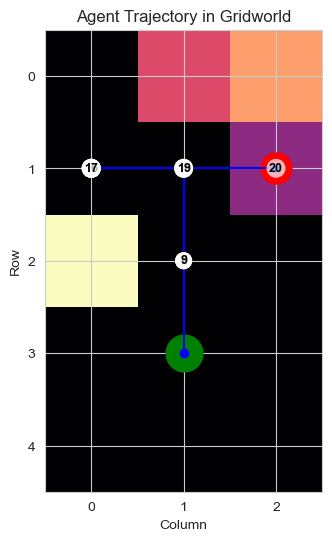

In [33]:
# Extract agent positions
positions = []
for i, g in enumerate(lstm_outputcalculator.dataset_train):
    agg_g = np.sum(g[0].detach().numpy(), axis=2)
    pos = np.argwhere((agg_g == 1) | (agg_g == 2))
    if pos.size > 0:
        positions.append(pos[0])
    if lstm_outputcalculator.rewards[i] == 1:
        break

positions = np.array(positions)
timesteps = np.arange(1, len(positions)+1)

# Plot agent trajectory with visit heatmap

visit_counts = np.zeros((5, 3), dtype=int)
for r, c in positions:
    visit_counts[r, c] += 1

plt.figure(figsize=(5,6),)
plt.imshow(agg_g, cmap = 'magma', vmin=0, vmax=5)  # base grid size
# plt.imshow(visit_counts, cmap='YlOrRd')
plt.plot(positions[:,1], positions[:,0], '-o', color='blue', label='Trajectory')
plt.scatter(positions[0,1], positions[0,0], color='green', s=700, label='Start')
plt.scatter(positions[-1,1], positions[-1,0], color='red', s=500, label='End')

# plot transition number 
for i in range(len(positions)-1):
    x_start, y_start = positions[i,1], positions[i,0]
    x_end, y_end = positions[i+1,1], positions[i+1,0]
    dx, dy = x_end - x_start, y_end - y_start
    # plt.arrow(x_start, y_start, dx*0.9, dy*0.9, 
    #           head_width=0.15, head_length=0.2, 
    #           fc='orange', ec='orange', alpha=0.8)

        # Label the transition number near the arrow midpoint
    # mid_x, mid_y = x_start + dx/2, y_start + dy/2
    plt.text(x_end, y_end, str(i+1), color='black',
             fontsize=9, fontweight='bold', ha='center', va='center',
             bbox=dict(boxstyle="circle,pad=0.2", fc="white", ec="none", alpha=0.7))



# plt.gca().invert_yaxis()
plt.title("Agent Trajectory in Gridworld")
plt.xlabel("Column")
plt.ylabel("Row")
plt.xticks(range(3))
plt.yticks(range(5))

# plt.legend()
# plt.savefig("coginterp/singleagent_traj_5.png", dpi=300)
plt.show()


# dual task agent path

MovieWriter ffmpeg unavailable; using Pillow instead.


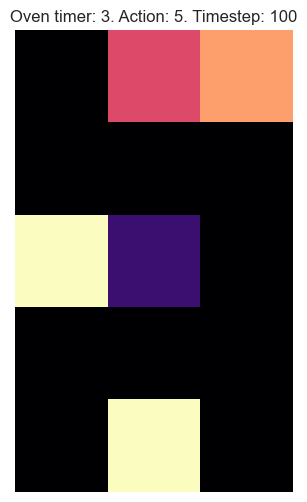

In [20]:
# animation
animate_path(lstm_dualtask_outputcalculator, "lstm_dualtask_animation.gif")

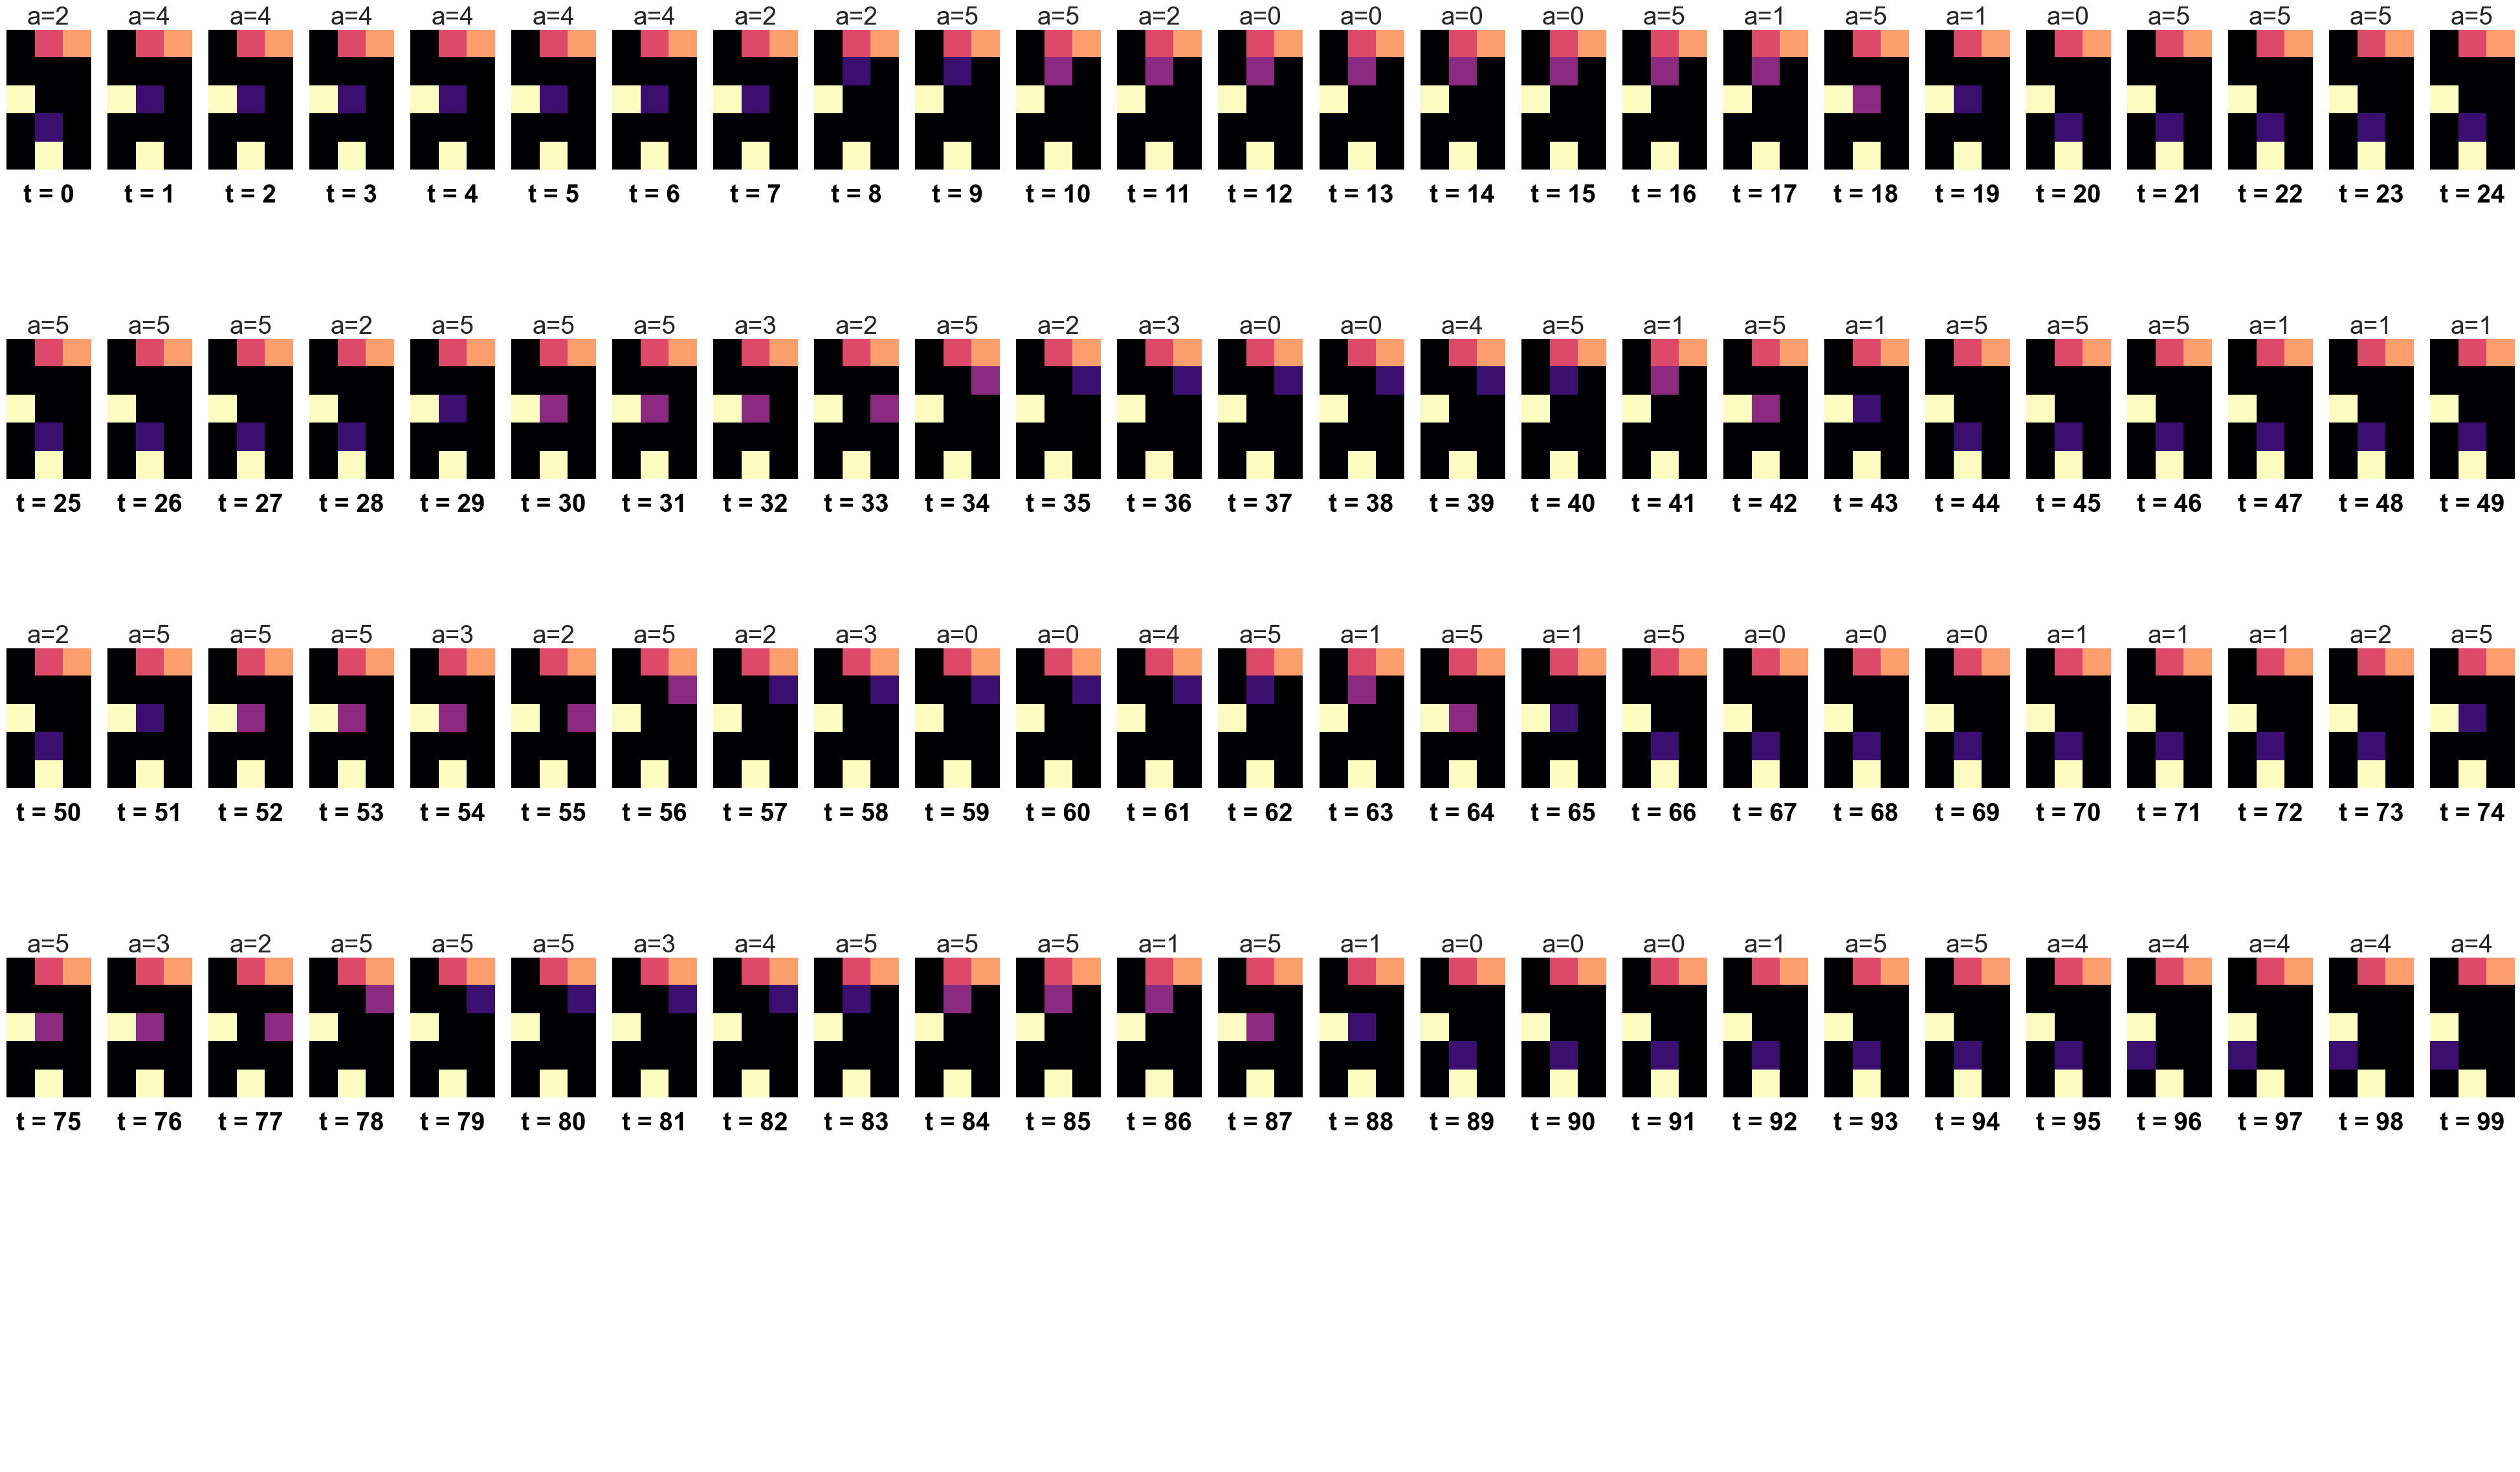

In [35]:
# display frames
num_frames = len(lstm_dualtask_outputcalculator.dataset_train[0:100])

# Select up to 125 timesteps evenly spaced
max_frames = 5 * 25
timesteps = np.linspace(0, num_frames-1, min(num_frames, max_frames), dtype=int)

rows, cols = 5, 25
fig, axes = plt.subplots(rows, cols, figsize=(50, 30))  # adjust figsize as needed

for idx, t in enumerate(timesteps):
    row = idx // cols
    col = idx % cols

    img = np.sum(lstm_dualtask_outputcalculator.dataset_train[t][0].detach().numpy(), axis=2)
    axes[row, col].imshow(img, cmap = 'magma', vmin=0, vmax=5)

    axes[row, col].set_title(f"a={lstm_dualtask_outputcalculator.actions[t]}", fontsize=28)
    axes[row, col].text(1, 5, f"t = {t}", color='black', fontsize=28,
        ha='center', va='top', fontweight='bold')
    axes[row, col].axis('off')

# Hide any unused subplots
for idx in range(len(timesteps), rows*cols):
    row = idx // cols
    col = idx % cols
    axes[row, col].axis('off')

# fig.suptitle("Evolution of Input Frames Over Time", fontsize=14)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


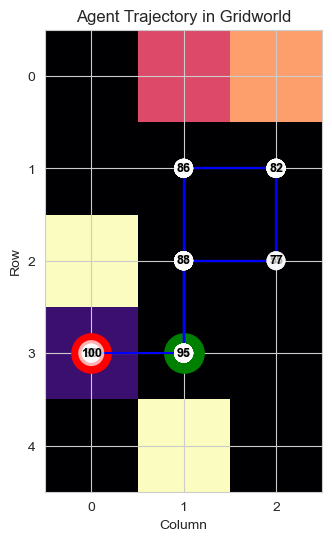

In [36]:
# dual task agent 
# Extract agent positions
positions_dual = []
for g in lstm_dualtask_outputcalculator.dataset_train:
    agg_g = np.sum(g[0].detach().numpy(), axis=2)
    # print(agg_g)
    pos = np.argwhere((agg_g == 1) | (agg_g == 2))
    if pos.size > 0:
        positions_dual.append(pos[0])

    # if lstm_dualtask_outputcalculator.rewards[i] == 1:
        # break

positions_dual = np.array(positions_dual)
timesteps_dual = np.arange(1, len(positions_dual)+1)

# Plot dual agent trajectory with visit heatmap

visit_counts_dual = np.zeros((5, 3), dtype=int)
for r, c in positions_dual:
    visit_counts_dual[r, c] += 1

plt.figure(figsize=(5,6))
plt.imshow(agg_g,  cmap = 'magma', vmin=0, vmax=5)  # base grid size
# plt.imshow(visit_counts_dual, cmap='YlOrRd')
plt.plot(positions_dual[:,1], positions_dual[:,0], '-o', color='blue', label='Trajectory')
plt.scatter(positions_dual[0,1], positions_dual[0,0], color='green', s=800, label='Start')
plt.scatter(positions_dual[-1,1], positions_dual[-1,0], color='red', s=800, label='End')

# add transition numbers
for i in range(len(positions_dual)-1):
    x_start, y_start = positions_dual[i,1], positions_dual[i,0]
    x_end, y_end = positions_dual[i+1,1], positions_dual[i+1,0]
    dx, dy = x_end - x_start, y_end - y_start

    plt.text(x_end, y_end, str(i+1), color='black',
             fontsize=9, fontweight='bold', ha='center', va='center',
             bbox=dict(boxstyle="circle,pad=0.2", fc="white", ec="none", alpha=0.7))

# plt.gca().invert_yaxis()
plt.title("Agent Trajectory in Gridworld")
plt.xlabel("Column")
plt.ylabel("Row")
plt.xticks(range(3))
plt.yticks(range(5))
# plt.legend()
# plt.grid(True)
# plt.savefig("coginterp/dualagent_traj_5.png", dpi=300)
plt.show()

In [76]:
first_oven_checks_dualtask_dict[5]

{8: [9, 10, 10, 10]}

In [16]:
total_reward_dualtask_dict

{8: [np.int64(12),
  np.int64(14),
  np.int64(13),
  np.int64(0),
  np.int64(0),
  np.int64(12),
  np.int64(12),
  np.int64(12),
  np.int64(14),
  np.int64(13),
  np.int64(15),
  np.int64(14),
  np.int64(13),
  np.int64(12),
  np.int64(11),
  np.int64(13),
  np.int64(13),
  np.int64(14),
  np.int64(11),
  np.int64(15),
  np.int64(14),
  np.int64(13),
  np.int64(13),
  np.int64(15),
  np.int64(14)]}

# time error distribution for the two variants

In [208]:
dur7_distribution = pd.DataFrame([first_oven_checks_dict[7], first_oven_checks_dualtask_dict[7][0:175]]).transpose()

In [34]:
len(first_oven_checks_dict[8]), len(first_oven_checks_dualtask_dict[8])

(82, 191)

In [33]:
pd.DataFrame([first_oven_checks_dict[8][0:100], first_oven_checks_dualtask_dict[8][0:100]]).transpose()

0     1
0   7.0   9.0
1   7.0   9.0
2   9.0   8.0
3   7.0   9.0
4   7.0  10.0
..  ...   ...
95  NaN  10.0
96  NaN  10.0
97  NaN   9.0
98  NaN  10.0
99  NaN   9.0

[100 rows x 2 columns]

In [13]:
def get_dur_distribution(target_duration):
    dur_distribution = pd.DataFrame([first_oven_checks_dict[target_duration][0:100], first_oven_checks_dualtask_dict[target_duration][0:100]]).transpose()
    dur_distribution = dur_distribution[(dur_distribution[0]<20) & (dur_distribution[1]<20)].reset_index(drop=True) 
    stat, pval = stats.ttest_ind(dur_distribution[0], dur_distribution[1], nan_policy="omit")
    print(stats.ttest_ind(dur_distribution[0], dur_distribution[1], nan_policy="omit"))
    print(stats.mannwhitneyu(dur_distribution[0], dur_distribution[1], nan_policy="omit"))
    # print(dur_distribution.describe())
    return dur_distribution, stat, pval

In [14]:
def compare_same_task(target_duration1, target_duration2):
    dur_distribution = pd.DataFrame([first_oven_checks_dict[target_duration1][0:100], first_oven_checks_dict[target_duration2][0:100]]).transpose()
    print(stats.ttest_ind(dur_distribution[0], dur_distribution[1], nan_policy="omit"))
    print(dur_distribution.describe())

TtestResult(statistic=np.float64(-11.25710900544879), pvalue=np.float64(4.832660909243714e-23), df=np.float64(198.0))
MannwhitneyuResult(statistic=np.float64(955.0), pvalue=np.float64(2.9323593832951965e-24))
TtestResult(statistic=np.float64(-23.920996728962663), pvalue=np.float64(5.543121662415832e-56), df=np.float64(168.0))
MannwhitneyuResult(statistic=np.float64(160.5), pvalue=np.float64(2.3530538222772056e-30))
TtestResult(statistic=np.float64(-13.486595430455935), pvalue=np.float64(7.844671525293753e-30), df=np.float64(198.0))
MannwhitneyuResult(statistic=np.float64(1045.5), pvalue=np.float64(5.2078995120511606e-23))
TtestResult(statistic=np.float64(-15.158348671336377), pvalue=np.float64(5.214898513160289e-30), df=np.float64(124.0))
MannwhitneyuResult(statistic=np.float64(140.5), pvalue=np.float64(7.269141255738875e-21))


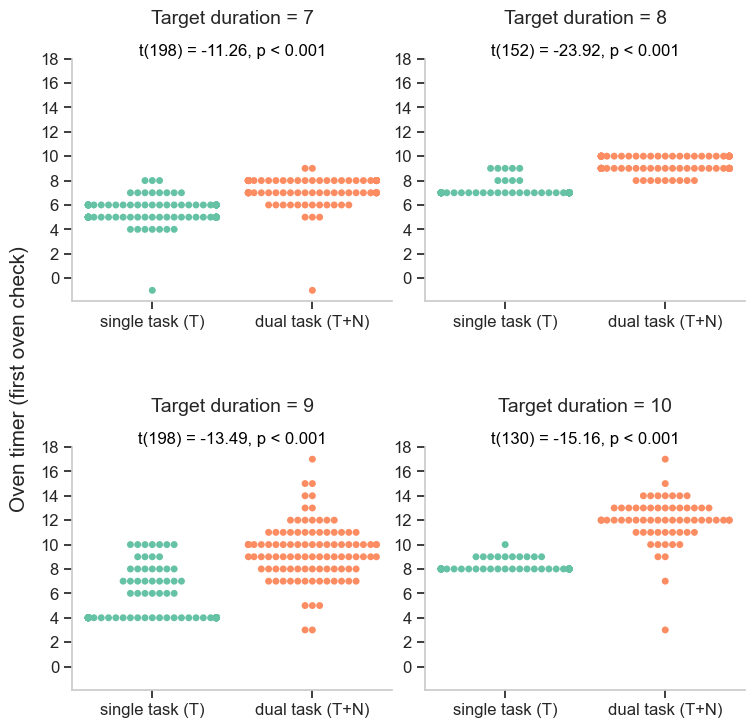

In [64]:
sns.set_context("notebook", font_scale=1.5)  # scale all text sizes

data_dur = []
stat_dic = {}
pval_dic = {}

for i, dur in enumerate([7, 8, 9, 10]):
    sub_df, stat, pval = get_dur_distribution(dur)
    stat_dic[dur] = stat
    pval_dic[dur] = pval
    sub_df.columns = ["single task (T)", "dual task (T+N)"]
    long_df = sub_df.melt(var_name='task type', value_name='time steps (first oven check)')
    long_df["duration"] = dur
    data_dur.append(long_df)

data_dur = pd.concat(data_dur, ignore_index=True)

# Plot
g = sns.catplot(
    data=data_dur,
    x='task type',
    y='time steps (first oven check)',
    col='duration',
    kind='swarm',
    palette='Set2',
    col_wrap=2,
    height=4,
    aspect=1,
    sharex=False,

)

# Axis and title fonts
g.set_axis_labels("", "Oven timer (first oven check)", fontsize=14)
g.set_titles("Target duration = {col_name}", size=14, pad = 25)

for i, dur in enumerate([7, 8, 9, 10]):
    ax = g.axes.flat[i]

    stat, pval = stat_dic[dur], pval_dic[dur]
    if dur in [7,9]:
        p_text = f"t(198) = {round(stat,2)}, p = {pval:.3f}" if pval >= 0.001 else f"t(198) = {round(stat,2)}, p < 0.001"
    elif dur == 8:
        p_text = f"t(152) = {round(stat,2)}, p = {pval:.3f}" if pval >= 0.001 else f"t(152) = {round(stat,2)}, p < 0.001"
    else:
        p_text = f"t(130) = {round(stat,2)}, p = {pval:.3f}" if pval >= 0.001 else f"t(130) = {round(stat,2)}, p < 0.001"

    ax.text(
        0.5, 1, p_text,
        ha='center', va='bottom',
        fontsize=12,
        color='black',
        transform=ax.get_xaxis_transform()
    )

# Adjust spacing
g.fig.subplots_adjust(hspace=0.6)
plt.yticks(range(0, 20, 2), fontsize=15)

g.set_ylabels("")

# Set shared y-axis label
# g.set_ylabels("Oven timer (first oven check)", fontsize=15)
g.fig.text(0.04, 0.5, "Oven timer (first oven check)", va='center', rotation='vertical', fontsize=15)


# If needed, set x and y tick labels font size
for ax in g.axes.flatten():
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=12)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')


plt.subplots_adjust(top=0.9)
# plt.ylabel("task type", fontsize=13)

# Save and show
plt.show()
# g.savefig("coginterp/first_oven_check_distributions_100timesteps.png", dpi=300, bbox_inches='tight')

# fft 

In [363]:

layer_output_obj = {}

for target_duration in [8]:
    reward_check = 0
    env_dur = OverCookedSingleAgentOneOven(oven_duration=target_duration)
    env_dualtask_dur = OverCookedSingleAgentDualtask(oven_duration=target_duration)

    if target_duration!=8:
        model_lstm = RecurrentPPO.load(f"models/singleagentv3_oneoven_T{target_duration}_cnnoutput125_timestep500_entcoef05_cnnlstmmlp_logs/rl_model_100000_steps", env=env_dur)
        
        model_dualtask= RecurrentPPO.load(f"models/singleagentv3_clblock_T{target_duration}_cnnoutput125_timestep500_entcoef05_cnnlstmmlp_logs/rl_model_100000_steps", env=env_dualtask_dur)
    
    else:
        model_lstm = RecurrentPPO.load(f"models/singleagentv3_oneoven_T{target_duration}_cnnoutput125_timestep500_entcoef05_cnnlstmmlp_logs/rl_model_100000_steps", env=env_dur)
        model_dualtask= RecurrentPPO.load(f"models/singleagent_clblock_T{target_duration}_timesteps500_entoef05_logs/rl_model_100000_steps", env=env_dualtask_dur)
    
    # else:
    #     continue
    
    wrapped_lstm_model = sb3CnnLstmMlpWrapper(model_lstm)
    wrapped_lstm_dualtask_model = sb3CnnLstmMlpWrapper(model_dualtask)
    
    
    lstm_outputcalculator = LayerOutputCalculator(wrapped_lstm_model, model_lstm, env_dur)
    # cnn_outputcalculator = LayerOutputCalculator(wrapped_cnnmlp_t8_model,model_cnnmlp_t8, env_dur8, has_lstm=False)
    lstm_dualtask_outputcalculator = LayerOutputCalculator(wrapped_lstm_dualtask_model, model_dualtask, env_dualtask_dur)
    
        

        
    while True:
        first_obs,_ = env_dur.reset(seed=10)
        if np.where(first_obs[:,:,1]==1) == (4,1) : 
            print("duration not processed", target_duration)
            continue
        break

    lstm_outputcalculator.get_layer_outputs_per_episode(first_obs)
    lstm_dualtask_outputcalculator.get_layer_outputs_per_episode(first_obs, timesteps=201)
    layer_output_obj[f"single_task_{target_duration}"] = lstm_outputcalculator
    layer_output_obj[f"dual_task_{target_duration}"] = lstm_dualtask_outputcalculator



  

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[[0 3 4]
 [0 0 0]
 [5 0 0]
 [0 1 0]
 [0 0 0]]
action 0
reward 0
timestep 1
oven timer -1
[[0 3 4]
 [0 0 0]
 [5 0 0]
 [0 1 0]
 [0 0 0]]
action 2
reward 0
timestep 2
oven timer -1
[[0 3 4]
 [0 0 0]
 [5 1 0]
 [0 0 0]
 [0 0 0]]
action 2
reward 0
timestep 3
oven timer -1
[[0 3 4]
 [0 1 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 4
reward 0
timestep 4
oven timer -1
[[0 3 4]
 [1 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 4
reward 0
timestep 5
oven timer -1
[[0 3 4]
 [1 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 5
reward 0
timestep 6
oven timer -1
[[0 3 4]
 [1 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 4
reward 0
timestep 7
oven timer -1
[[0 3 4]
 [1 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 1
reward 0
timestep 8
oven timer -1
[[0 3 4]
 [1 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]
action 2
reward 0
timestep 9
oven timer -1
[[1 3 4]
 [0 0 0]
 [5 0 0]
 [0 0 0]
 [0 0 0]]

In [329]:
layer_output_obj.keys()

dict_keys(['single_task_8', 'dual_task_8'])

explained_variance policy [0.19483034 0.17041907]
explained_variance value [0.2108249  0.19712274]


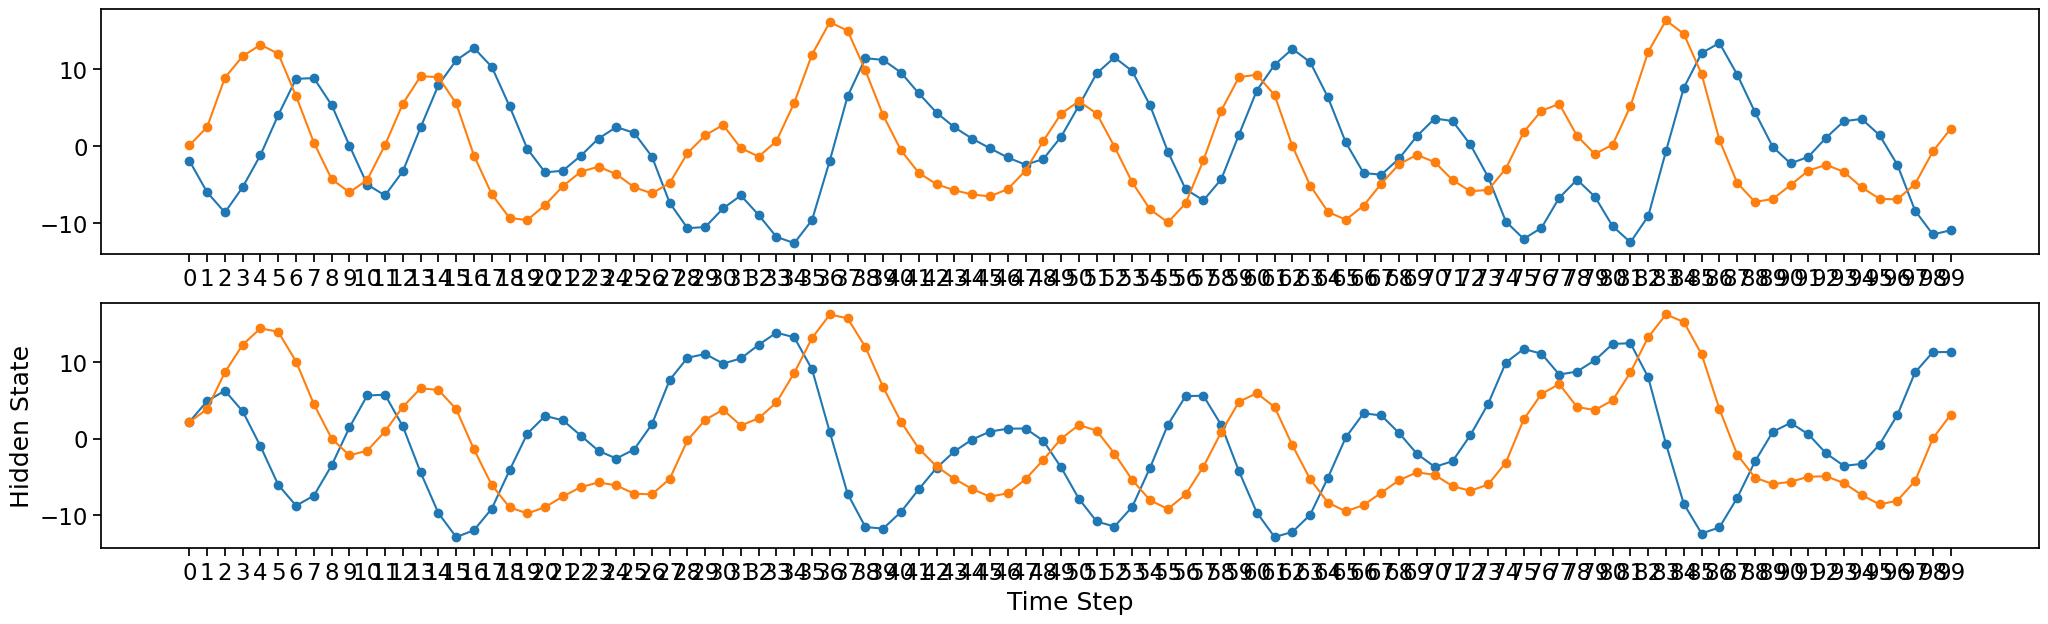

explained_variance policy [0.21557495 0.17620905]
explained_variance value [0.25163808 0.18519239]


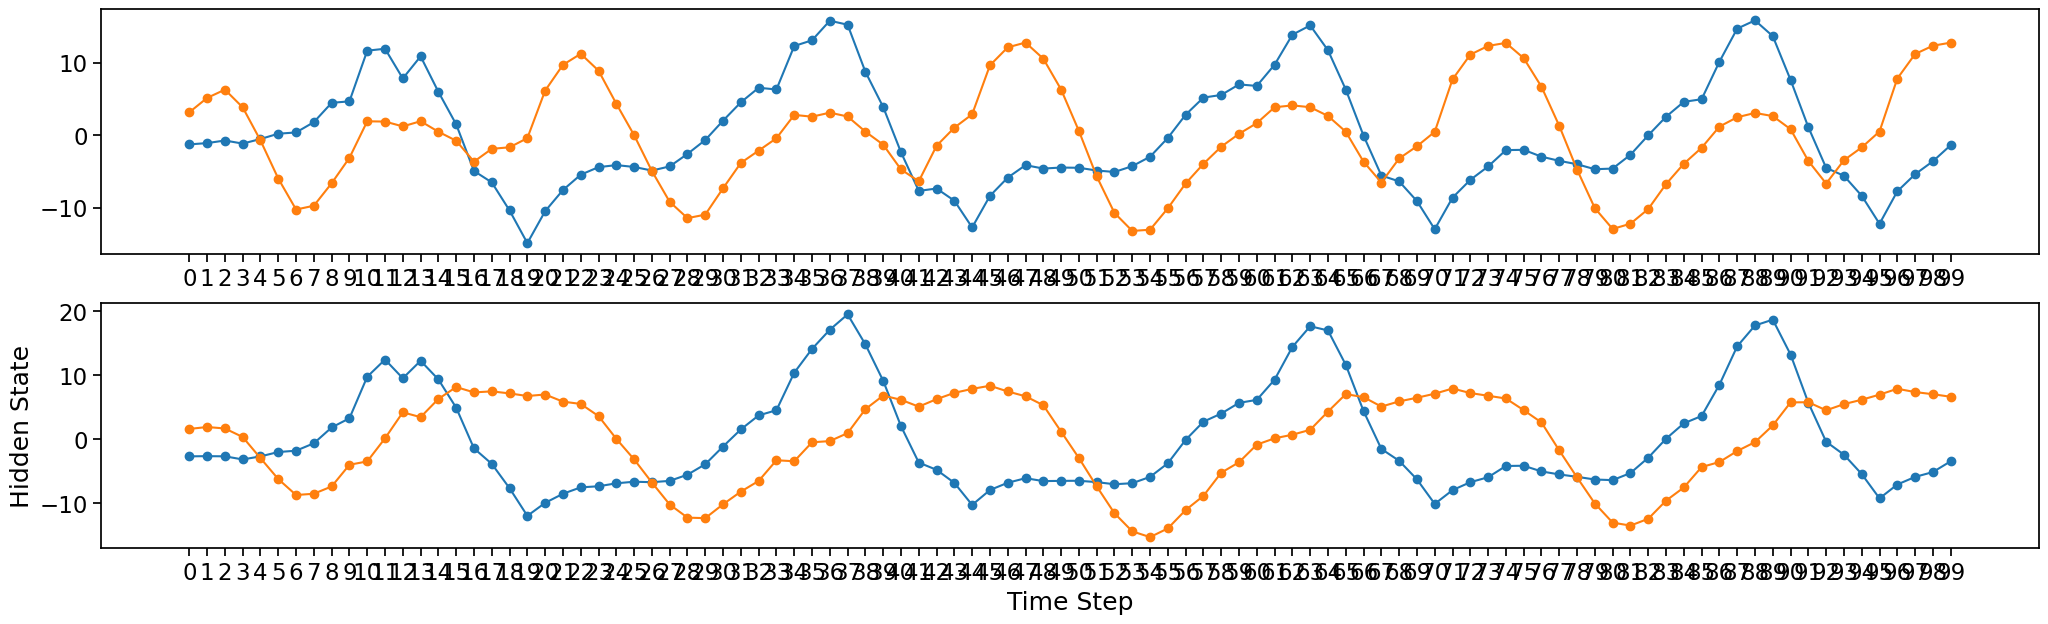

In [431]:
target_duration = 10

fft_mag_dur = {}
fft_mag_dur_dualtask = {}
freq_dur = {}
timesteps_dur = {}

for target_duration in [8]:
    squeezed_lstm_policy = np.array(layer_output_obj[f"single_task_{target_duration}"].lstm_hidden).squeeze(1).squeeze(1)[:100,:]
    squeezed_lstm_cell = np.array(layer_output_obj[f"single_task_{target_duration}"].lstm_cell).squeeze(1).squeeze(1)[:100,:]
    
    squeezed_lstm_dual_task = np.array(layer_output_obj[f"dual_task_{target_duration}"].lstm_hidden).squeeze(1).squeeze(1)[:100,:]
    squeezed_lstm_cell_dual_task = np.array(layer_output_obj[f"dual_task_{target_duration}"].lstm_cell).squeeze(1).squeeze(1)[:100,:]
    
    hidden_pca, cell_pca = pca(squeezed_lstm_policy, squeezed_lstm_cell, pca_components=2)
    hidden_pca_dualtask, cell_pca_dualtask = pca(squeezed_lstm_dual_task, squeezed_lstm_cell_dual_task, pca_components=2)
    
    squeezed_policy_layer = hidden_pca[:,0:1]
    squeezed_policy_layer_dualtask = hidden_pca_dualtask[:,0:1]
    
    # squeezed_policy_layer = squeezed_lstm_policy
    # squeezed_policy_layer_dualtask = squeezed_lstm_dual_task
    
    
    squeezed_policy_layer_NT = squeezed_policy_layer.T # Shape: (N, T)
    squeezed_policy_layer_dualtask_NT = squeezed_policy_layer_dualtask.T # Shape: (N, T)
    
    # Apply FFT to each neuron's time series
    fft_policy_results = np.fft.fft(squeezed_policy_layer_NT, axis=1)
    fft_policy_magnitudes = np.abs(fft_policy_results)
    fft_mag_dur[target_duration] = fft_policy_magnitudes
    
    fft_policy_results_dualtask = np.fft.fft(squeezed_policy_layer_dualtask_NT, axis=1)
    fft_policy_magnitudes_dualtask = np.abs(fft_policy_results_dualtask)
    fft_mag_dur_dualtask[target_duration] = fft_policy_magnitudes_dualtask
    
    time_steps = squeezed_policy_layer.shape[0]
    timesteps_dur[target_duration] = time_steps 
    
    sampling_rate = 1  # 1 sample per timestep; change if you have a specific rate
    freqs = np.fft.fftfreq(time_steps, d=1/sampling_rate)
    freq_dur[target_duration] = freqs
    # fig, axes = plt.subplots(1, 1, figsize=(25, 7))
    # for i in range(squeezed_policy_layer.shape[1]):
    #     plt.plot(freqs[:time_steps // 2], fft_policy_magnitudes[i, :time_steps // 2],marker="o", alpha=0.5, color="blue", linestyle="--")
    #     plt.plot(freqs[:time_steps // 2], fft_policy_magnitudes_dualtask[i, :time_steps // 2],marker="o", alpha=0.5, color="red", linestyle="--")
    # plt.axvline(x=1/target_duration, color='black', linestyle='--', linewidth=1.2, alpha=0.7)

In [466]:
def pca(squeezed_policy_layer, squeezed_value_layer, pca_components=3, total_timestep=100):
    scaler_policy = StandardScaler()
    scaler_value = StandardScaler()

    policy_layer_scaled = scaler_policy.fit_transform(squeezed_policy_layer)
    value_layer_scaled = scaler_value.fit_transform(squeezed_value_layer)

    pca_policy = PCA(n_components=pca_components)
    pca_value = PCA(n_components=pca_components)

    policy_layer_pc = pca_policy.fit_transform(policy_layer_scaled)
    value_layer_pc = pca_value.fit_transform(value_layer_scaled)

    explained_variance_policy = pca_policy.explained_variance_ratio_
    explained_variance_value = pca_value.explained_variance_ratio_

    print("explained_variance policy", explained_variance_policy)
    print("explained_variance value", explained_variance_value)

    fig, axes = plt.subplots(1, 1, figsize=(25, 7))

    # Hidden state
    for i in range(pca_components):
        axes.plot(policy_layer_pc[:, i], marker="o", label=f'PC{i+1} ({explained_variance_policy[i]*100:.1f}%)')

    # axes.plot(policy_layer_pc, marker="o" , label=f'PC{i+1} ({np.round(explained_variance_policy*100,2)})')
    # axes[1].plot(value_layer_pc, marker="o" ,)
    # axes[0].set_xticks(range(0,policy_output.shape[0]))
    # axes[1].set_xticks(range(0,value_output.shape[0]))
    axes.set_xticks(range(0 ,total_timestep))
    axes.set_xticks(range(0,100,5))
    axes.legend(loc='upper right')
    # axes[1].set_xticks(range(0 ,total_timestep))
    plt.xlabel("Time Step")
    plt.ylabel("Hidden State")
    plt.show()
    return policy_layer_pc, value_layer_pc

explained_variance policy [0.21557495 0.17620905]
explained_variance value [0.25163808 0.18519239]


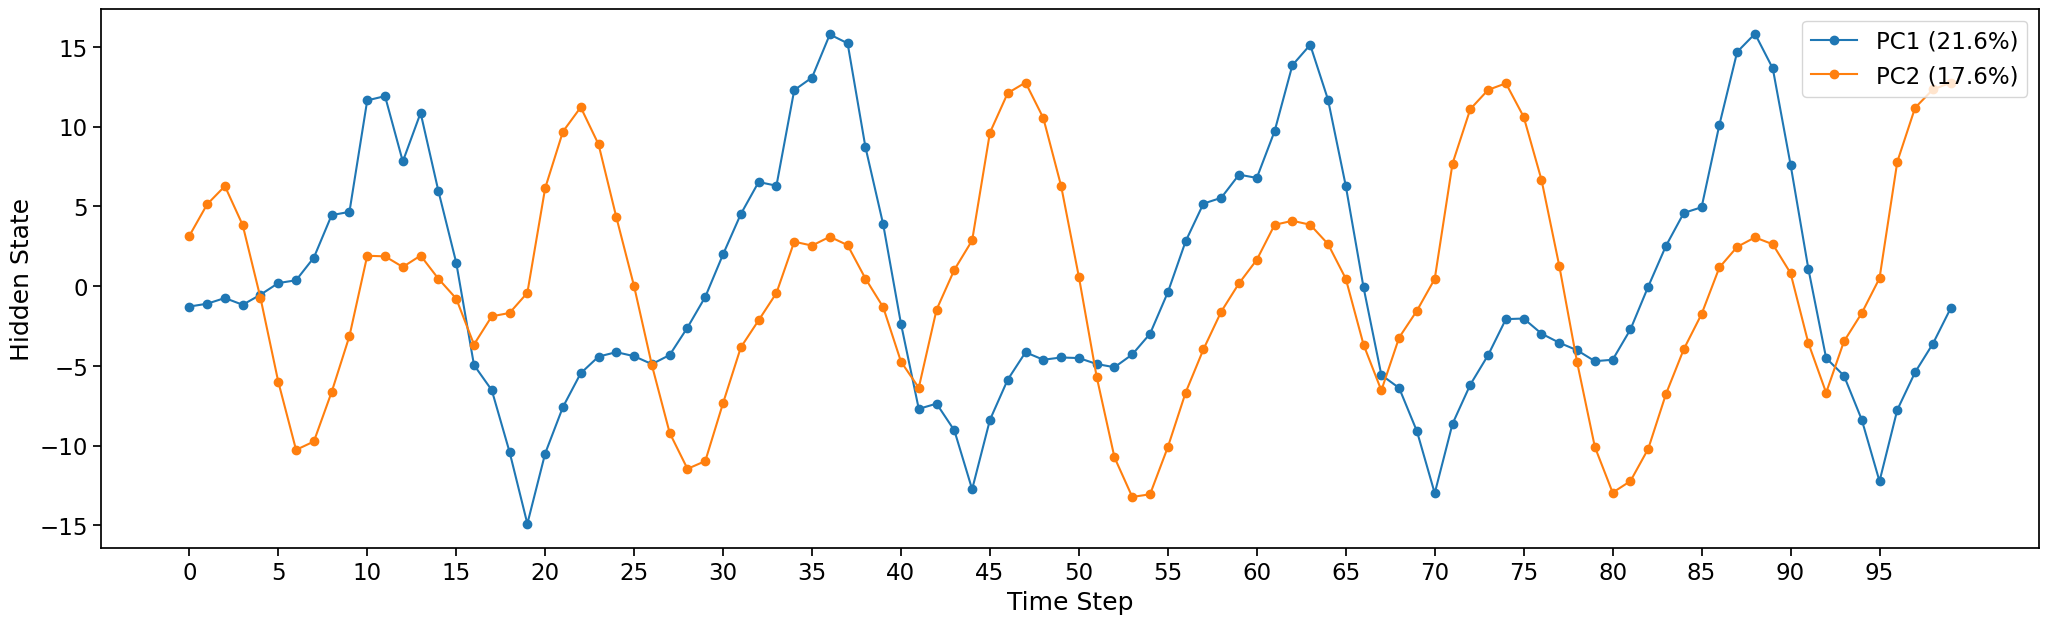

In [468]:
hidden_pca_dualtask, cell_pca_dualtask = pca(squeezed_lstm_dual_task, squeezed_lstm_cell_dual_task, pca_components=2)

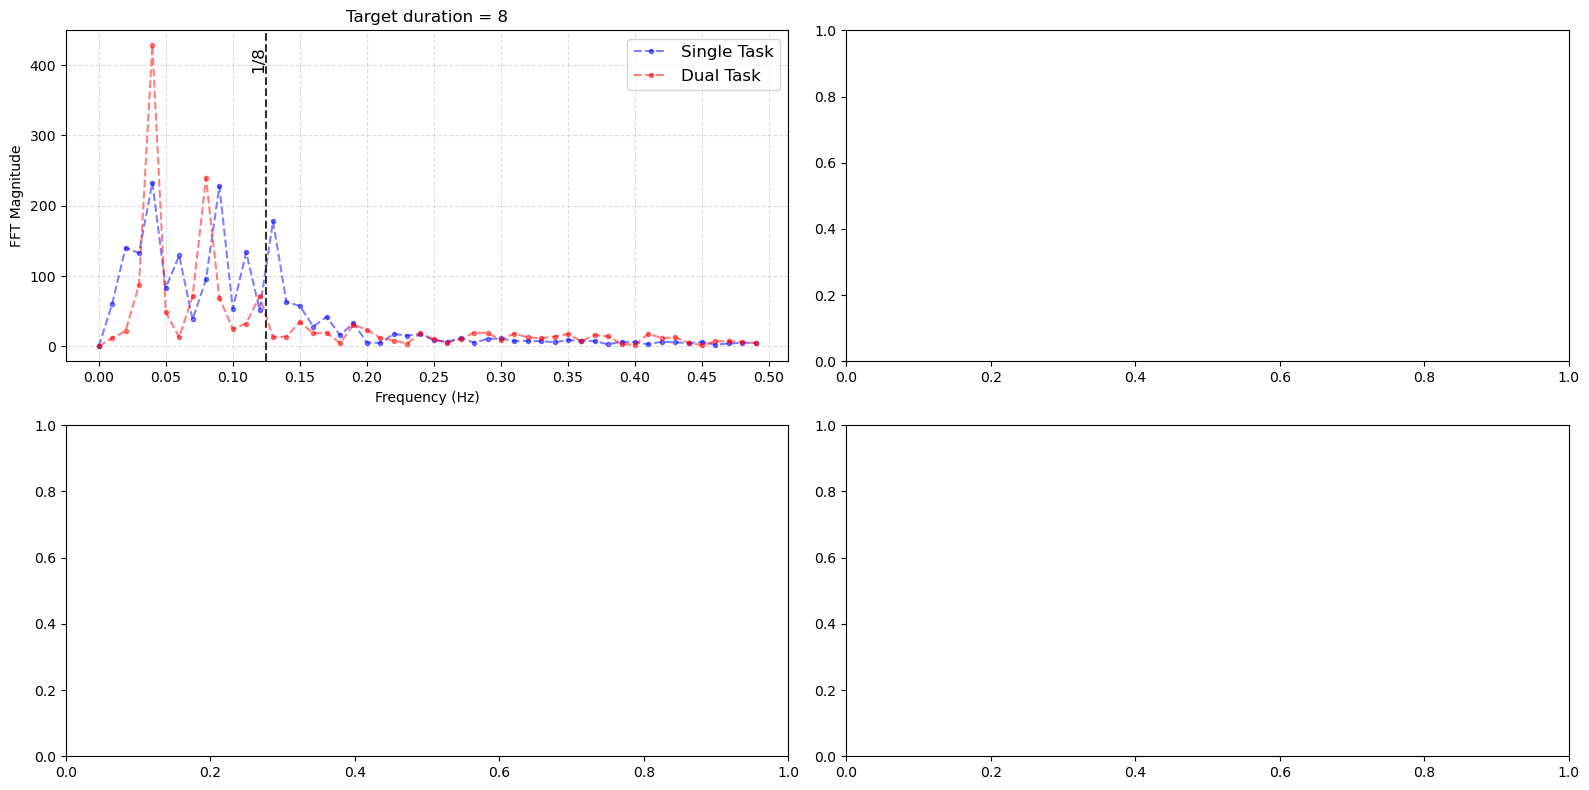

In [365]:
# import matplotlib.pyplot as plt

durations = [8]
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = axes.flatten()

for idx, dur in enumerate(durations):
    ax = axes[idx]

    freqs = freq_dur[dur]
    time = timesteps_dur[dur]
    fft_single = fft_mag_dur[dur]
    fft_dual = fft_mag_dur_dualtask[dur]

    for i in range(fft_single.shape[0]):
        ax.plot(freqs[:time // 2],
                fft_single[i, :time // 2],
                marker="o", markersize=3, alpha=0.5, color="blue", linestyle="--",
                label="Single Task" if i == 0 else "")

        ax.plot(freqs[:time // 2],
                fft_dual[i, :time // 2],
                marker="o", markersize=3, alpha=0.5, color="red", linestyle="--",
                label="Dual Task" if i == 0 else "")

    # Highlight 1/duration line
    inv_dur = 1 / dur
    ax.axvline(x=inv_dur, color='black', linestyle='--', linewidth=1.5, alpha=0.8)
    ax.text(inv_dur, ax.get_ylim()[1] * 0.95, f"1/{dur}", rotation=90,
            verticalalignment='top', horizontalalignment='right', fontsize=12, color='black')

    ax.set_title(f"Target duration = {dur}", fontsize=12)
    ax.set_xlabel("Frequency (Hz)")
    if idx % 2 == 0:
        ax.set_ylabel("FFT Magnitude")
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_xticks(np.arange(0, 0.55, 0.05))

# Add legend only once
axes[0].legend(loc='upper right', fontsize=12)
# plt.xticks(np.arange(0, 1.05, 0.05))
plt.tight_layout()
plt.show()
# fig.savefig("fft_policy_subplots.png", dpi=300)


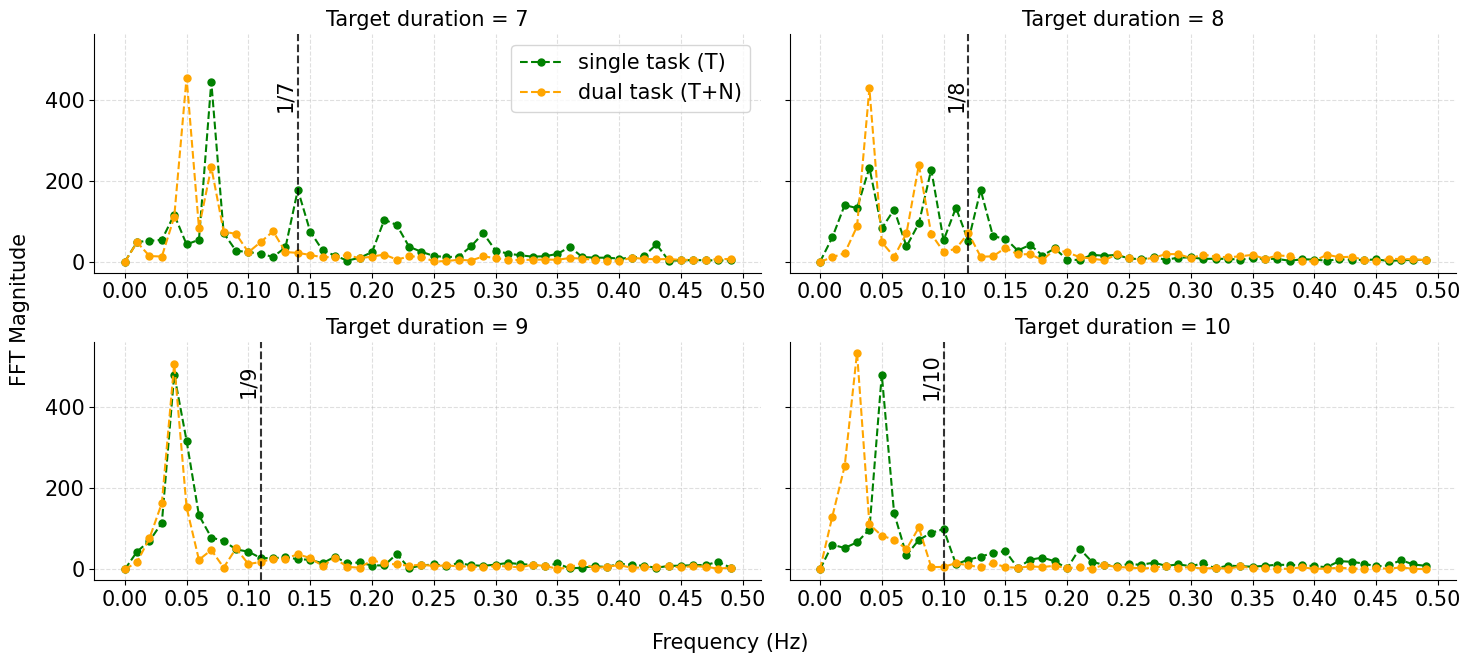

In [418]:
# import matplotlib.pyplot as plt

durations = [7, 8, 9, 10]
fig, axes = plt.subplots(2, 2, figsize=(15, 7), sharey=True)
axes = axes.flatten()

for idx, dur in enumerate(durations):
    ax = axes[idx]

    freqs = freq_dur[dur]
    time = timesteps_dur[dur]
    fft_single = fft_mag_dur[dur]
    fft_dual = fft_mag_dur_dualtask[dur]

    for i in range(fft_single.shape[0]):
        ax.plot(freqs[:time // 2],
                fft_single[i, :time // 2],
                marker="o", markersize=5, alpha=1, color="green", linestyle="--",
                label="single task (T)" if i == 0 else "")

        ax.plot(freqs[:time // 2],
                fft_dual[i, :time // 2],
                marker="o", markersize=5, alpha=1, color="orange", linestyle="--",
                label="dual task (T+N)" if i == 0 else "")

    # Highlight 1/duration line
    inv_dur = round(1 / dur, 2)
    ax.axvline(x=inv_dur, color='black', linestyle='--', linewidth=1.5, alpha=0.8)
    ax.text(inv_dur-0.002, ax.get_ylim()[1] * 0.95, f"1/{dur}", rotation=90,
            verticalalignment='top', horizontalalignment='right', fontsize=15, color='black')

    ax.set_title(f"Target duration = {dur}", fontsize=15)
    # ax.set_xlabel("Frequency (Hz)", fontsize=12)
    # if idx % 2 == 0:
    #     ax.set_ylabel("FFT Magnitude", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_xticks(np.arange(0, 0.55, 0.05))
    ax.tick_params(axis='both', labelsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add legend only once
axes[0].legend(loc='upper right', fontsize=15)
fig.supxlabel("Frequency (Hz)", fontsize=15)
fig.supylabel("FFT Magnitude", fontsize=15)
# plt.xticks(np.arange(0, 1.05, 0.05))
plt.tight_layout(rect=[0.01, 0, 1, 0.95]) 
plt.show()
fig.savefig("coginterp/fft_across_durations.png", dpi=300, bbox_inches='tight')
